# Lab 5-1: Turbulent fluxes and measures of stability

Written by Eli Schwat - January 2024.

In [1]:
import xarray as xr
import numpy as np
import os 
import urllib
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
import altair as alt

## SOS Data

In [2]:
sos_file = "../data/sos_full_dataset_30min.nc"
sos_dataset = xr.open_dataset(sos_file)

## Check out the flux measurements in their native units

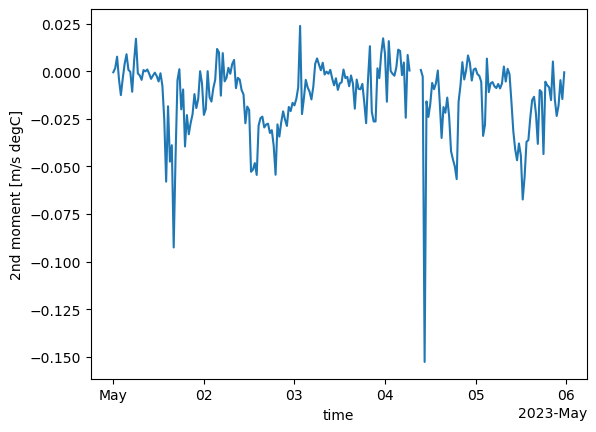

In [3]:
sos_dataset['w_tc__3m_c'].sel(time=slice('20230501', '20230505')).plot()

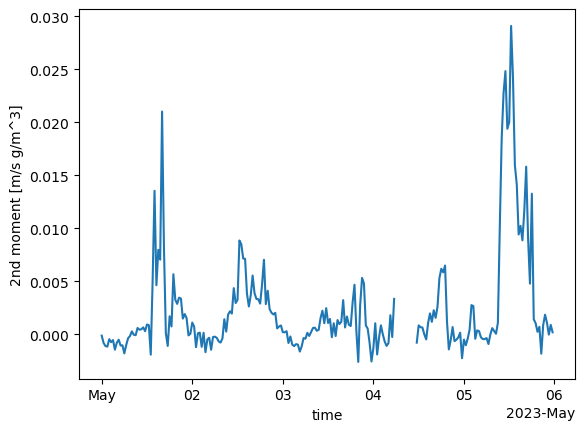

In [4]:
sos_dataset['w_h2o__3m_c'].sel(time=slice('20230501', '20230505')).plot()

## Convert turbulent fluxes to energy units

#### Converting turbulent latent heat flux measurements into energy flux units ($W/m^2$)

To convert `w_h2o__3m_c` (latent heat flux in $g/m^2/s$) to $W/m^2$, we will use the latent heat of sublimation (the sum of the latent heats of fusion and vaporization, $L_{sub} = 2590 J/g$).

$H_l = $ `w_h2o__3m_c` $ * L_{sub}$

and the units work out like this : $\frac{g}{m^2 s} * \frac{J}{g} = \frac{J}{m^2 s} = \frac{W}{m^2}$ (b/c 1 Watt = 1 Joule per second).

---
#### Converting turbulent sensible heat flux measurements into energy flux units ($W/m^2$)

To convert `w_tc__3m_c` (sensible heat flux in units $K m/s$) to $W/m^2$, we will use the specific heat capacity of air ($c_{p}^{air} = 1.005$ $J/K/g$) and the density of air ($\rho_{air} = 1000 g / m^3$). Note that we use the physical constants for air since it is air that is transporting heat away from the snowpack. 

$H_s = $ `w_tc__3m_c` $ * c_{p}^{air} * \rho_{air}$

and the units work out like this: $\frac{K m}{s} * \frac{J}{K g} * \frac{g}{m^3} = = \frac{W}{m^2}$

---

In [5]:
latent_heat_sublimation = 2590 #J/g
latent_heat_flux = sos_dataset['w_h2o__3m_c'] * latent_heat_sublimation

specific_heat_capacity_air = 1.005 # J/K/g
air_density = 1000 # g/m^3                                       
sensible_heat_flux = sos_dataset['w_tc__3m_c'] * specific_heat_capacity_air * air_density

# negating the measurements
sensible_heat_flux = sensible_heat_flux

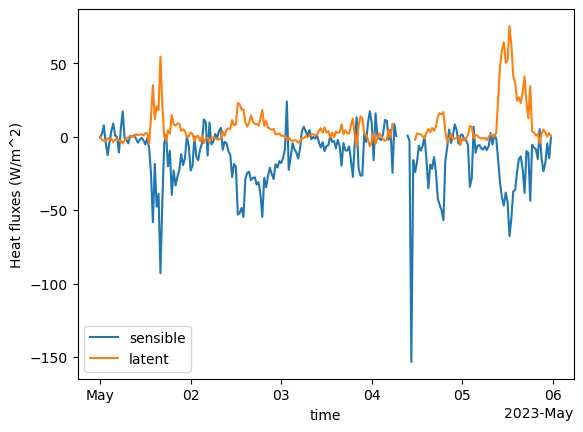

In [6]:
sensible_heat_flux.sel(time=slice('20230501', '20230505')).plot(label='sensible')
latent_heat_flux.sel(time=slice('20230501', '20230505')).plot(label='latent')
plt.ylabel('Heat fluxes (W/m^2)')
plt.legend()

Why do we think sensible heat and latent heat have an inverse relationship?

## Calculate Static Stability

Stability is characterized with many different methods. One of the simpler methods is to characterize the "static stability" - the stabiliy of the atmopshere due to stratification alone. This is done by using the gradient in potential temperature, 

$$\frac{d \theta}{dz}$$

Let's calculate the static stability of the atmosphere throughout the entire season. We will use a finite difference approximation to the derivative above using measurements at the snow surface and at 3 meters. We will also ignore the fact that the snow depth is fluctuating.

$$ \frac{d \theta}{d z} = \frac{\Delta \theta}{\Delta z} = \frac{\theta_{3m} - \theta_{surf}}{3}$$

In [7]:
T_vars = [
    'Tsurfpot_c', 'Tpot_3m_c', 
]
stability_df = sos_dataset[
    T_vars
    
].to_dataframe()
stability_df.head()

stability_df['static_stability'] = (stability_df['Tpot_3m_c'] - stability_df['Tsurfpot_c'])/3

### Compare static stability with sensible heat fluxes

In [8]:
sensible_heat_flux = sensible_heat_flux.to_dataframe().join(stability_df[['static_stability']])

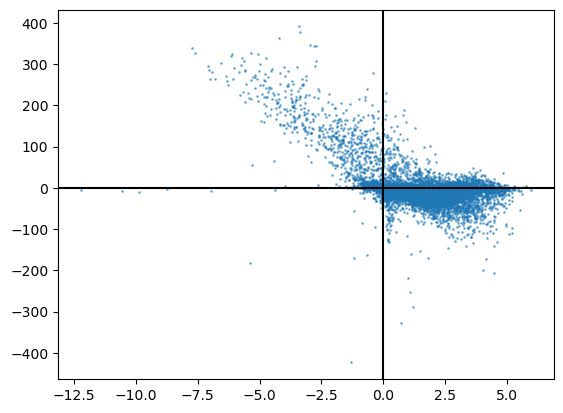

In [9]:
plt.scatter(
    sensible_heat_flux['static_stability'], sensible_heat_flux['w_tc__3m_c'],
    s=1, alpha=0.5
)
plt.axhline(0, color='black')
plt.axvline(0, color='black')

What pattern do we see? Why?

## Calculate Dynamic Stability

In [10]:
h = 3
g = 9.81
k = 0.4
theta_h = sos_dataset['Tpot_3m_c'] + 273.15
theta_s = sos_dataset['Tsurfpot_c'] + 273.15
u_h = sos_dataset['spd_3m_c']
Ri_bulk = g*h*(theta_h - theta_s)/(u_h**2 * 0.5*(theta_h + theta_s))

In [16]:
Ri_bulk.name = 'Ri_bulk'
sensible_heat_flux = sensible_heat_flux.join(Ri_bulk.to_dataframe())
sensible_heat_flux.head()

,w_tc__3m_c,static_stability,Ri_bulk
time,,,
2022-11-01 00:00:00,-1.798522,1.977773,0.833876
2022-11-01 00:30:00,-8.952477,1.909485,0.103544
2022-11-01 01:00:00,-0.394793,1.734680,0.209729
2022-11-01 01:30:00,-7.073821,1.545715,0.094483
2022-11-01 02:00:00,8.566571,1.438609,0.067049


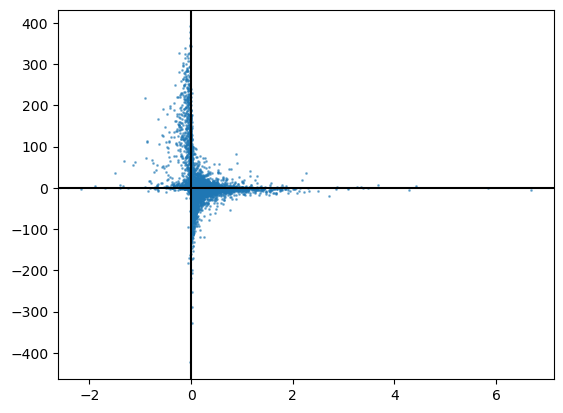

In [25]:
plt.scatter(
    sensible_heat_flux['Ri_bulk'], sensible_heat_flux['w_tc__3m_c'],
    s=1, alpha=0.5
)
plt.axhline(0, color='black')
plt.axvline(0, color='black')

How does the relationship between w'T' and dynamic stability (Ri) differ from the relationship between w'T' and static stability ($d \theta /dz$)

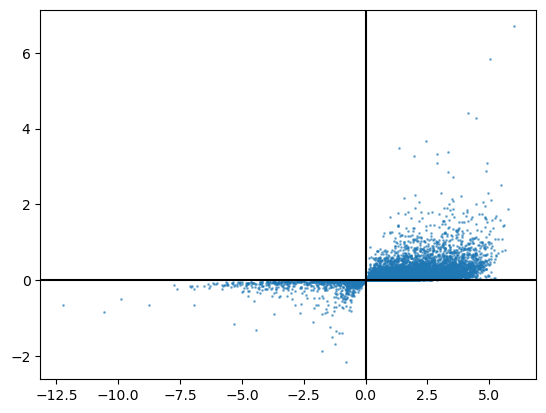

In [26]:
plt.scatter(
    sensible_heat_flux['static_stability'], sensible_heat_flux['Ri_bulk'],
    s=1, alpha=0.5
)
plt.axhline(0, color='black')
plt.axvline(0, color='black')

What pattern do we see? Why?